In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice

Connecting hanhou@datajoint.mesoscale-activity-map.org:3306


# Ephys examples

## Histology-related

`ephys.Unit`: all units

`histology.ElectrodeCCFPosition.ElectrodePosition`: CCF location for each unit

`ccf.CCFAnnotation`: Annotation for each CCF location

Count units in each area

In [2]:
dj.U('annotation').aggr((ephys.Unit * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:10]

,count
annotation,
Caudoputamen,30221
"Secondary motor area, layer 5",19607
arbor vitae,18867
Intermediate reticular nucleus,18607
Midbrain reticular nucleus,14389
Lobules IV-V,13608
Parvicellular reticular nucleus,11508
"Orbital area, lateral part, layer 5",11441
Gigantocellular reticular nucleus,10758


After unit QC (quite stringent)

In [4]:
foraging_session = experiment.Session & 'username = "hh"'
all_unit_qc = (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat) & foraging_session & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70'
dj.U('annotation').aggr(((ephys.Unit & all_unit_qc.proj()) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:10]

,count
annotation,
"Lateral septal nucleus, rostral (rostroventral) part",325
"Secondary motor area, layer 6a",289
"Prelimbic area, layer 5",286
"Anterior cingulate area, ventral part, layer 5",153
Anterior olfactory nucleus,135
"Anterior cingulate area, dorsal part, layer 5",132
"Orbital area, medial part, layer 5",118
Caudoputamen,116
"Lateral septal nucleus, ventral part",103


All unit in Prelimbic area after QC

In [5]:
unit_qc_prelimbic = (all_unit_qc * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation) & 'annotation LIKE "Prelimbic%"'

Unique `session` and `insertion_number` that contains Prelimbic area for Mouse HH09

(`insertion_number` could be 1, 2, or 3.  I can insert three probes at most on my current rig.)

In [ ]:
dj.U('session', 'insertion_number') & (unit_qc_prelimbic & (lab.WaterRestriction & 'water_restriction_number = "HH09"'))

Finally, all QC-filtered prelimbic units for Mouse HH09 in Session 47.

In [ ]:
unit_qc_prelimbic_HH09_session47 = unit_qc_prelimbic & (lab.WaterRestriction & 'water_restriction_number = "HH09"') & 'session = 47'
len(unit_qc_prelimbic_HH09_session47)

## PSTH

Pick an example neuron

In [2]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() & (experiment.Session & 'session_date = "2021-04-18"' & 'subject_id = 473361') & {'insertion_number': imec + 1, 'unit_uid': unit}).fetch1("KEY")

PSTH grouped by choice and outcome

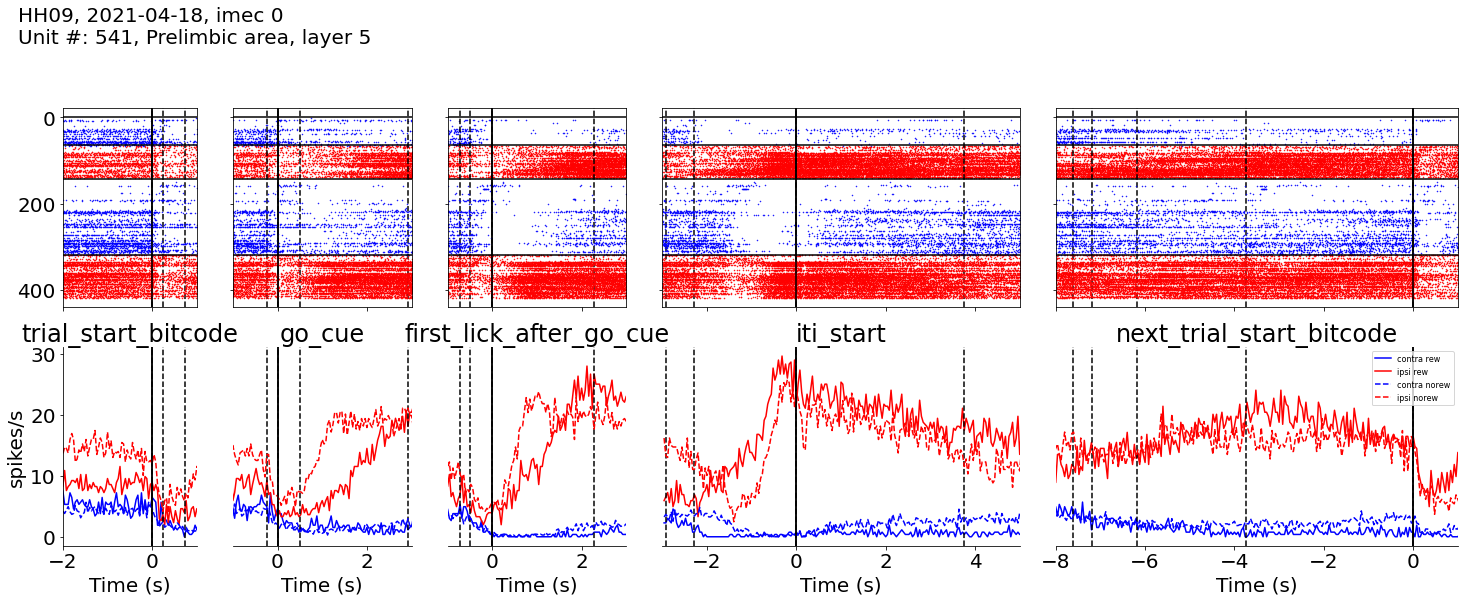

In [3]:
_ = unit_psth.plot_unit_psth_choice_outcome(unit_key)

PSTH grouped by quantiles of `action value`. Note that this depends on the behavioral model. (see the next section)

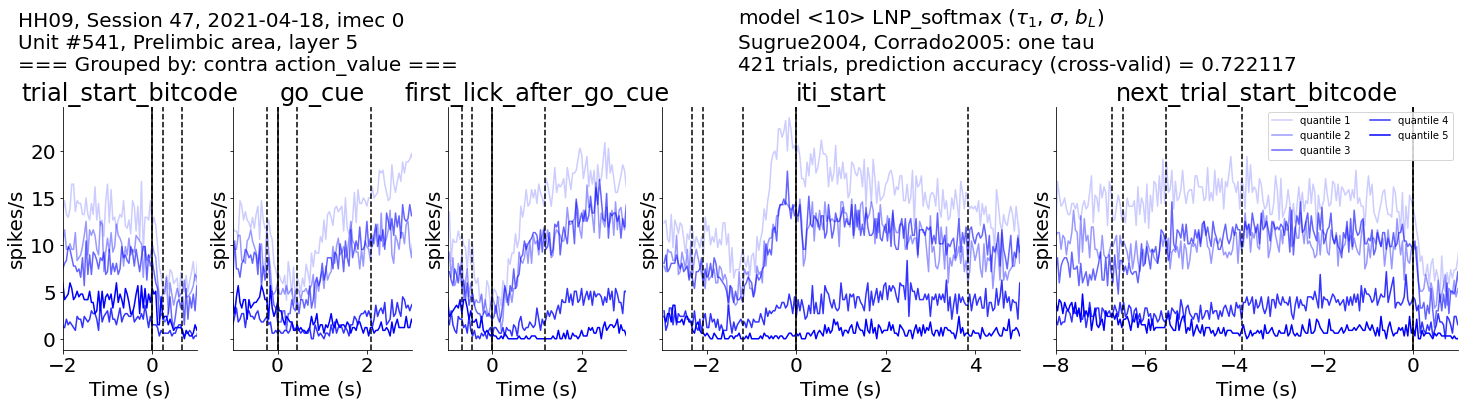

In [4]:
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10)

By default, `plot_unit_psth_latent_variable_quantile` plots `contralateral action value`.

You can specify other latent variables, such as `ipsi_action_value`, `contra_choice_prob`, `relative_action_value_ic` (contra-ipsi), `total_action_value`, `contra_choice_kernel` etc.

For example, ipsilateral choice probability:

In [ ]:
_ = unit_psth.plot_unit_psth_latent_variable_quantile(unit_key, model_id=10, latent_variable='total_action_value')

## Spike count over trials VS latent variables

In [11]:
date, imec, unit = '2021-04-18', 0, 541
unit_key = (ephys.Unit() & (experiment.Session & 'session_date = "2021-04-18"' & 'subject_id = 473361') & {'insertion_number': imec + 1, 'unit_uid': unit}).fetch1("KEY")

Function `unit_psth.plot_unit_period_tuning` plots spike counts in user-defined `period` over trials and do simple linear fitting against latent variables.

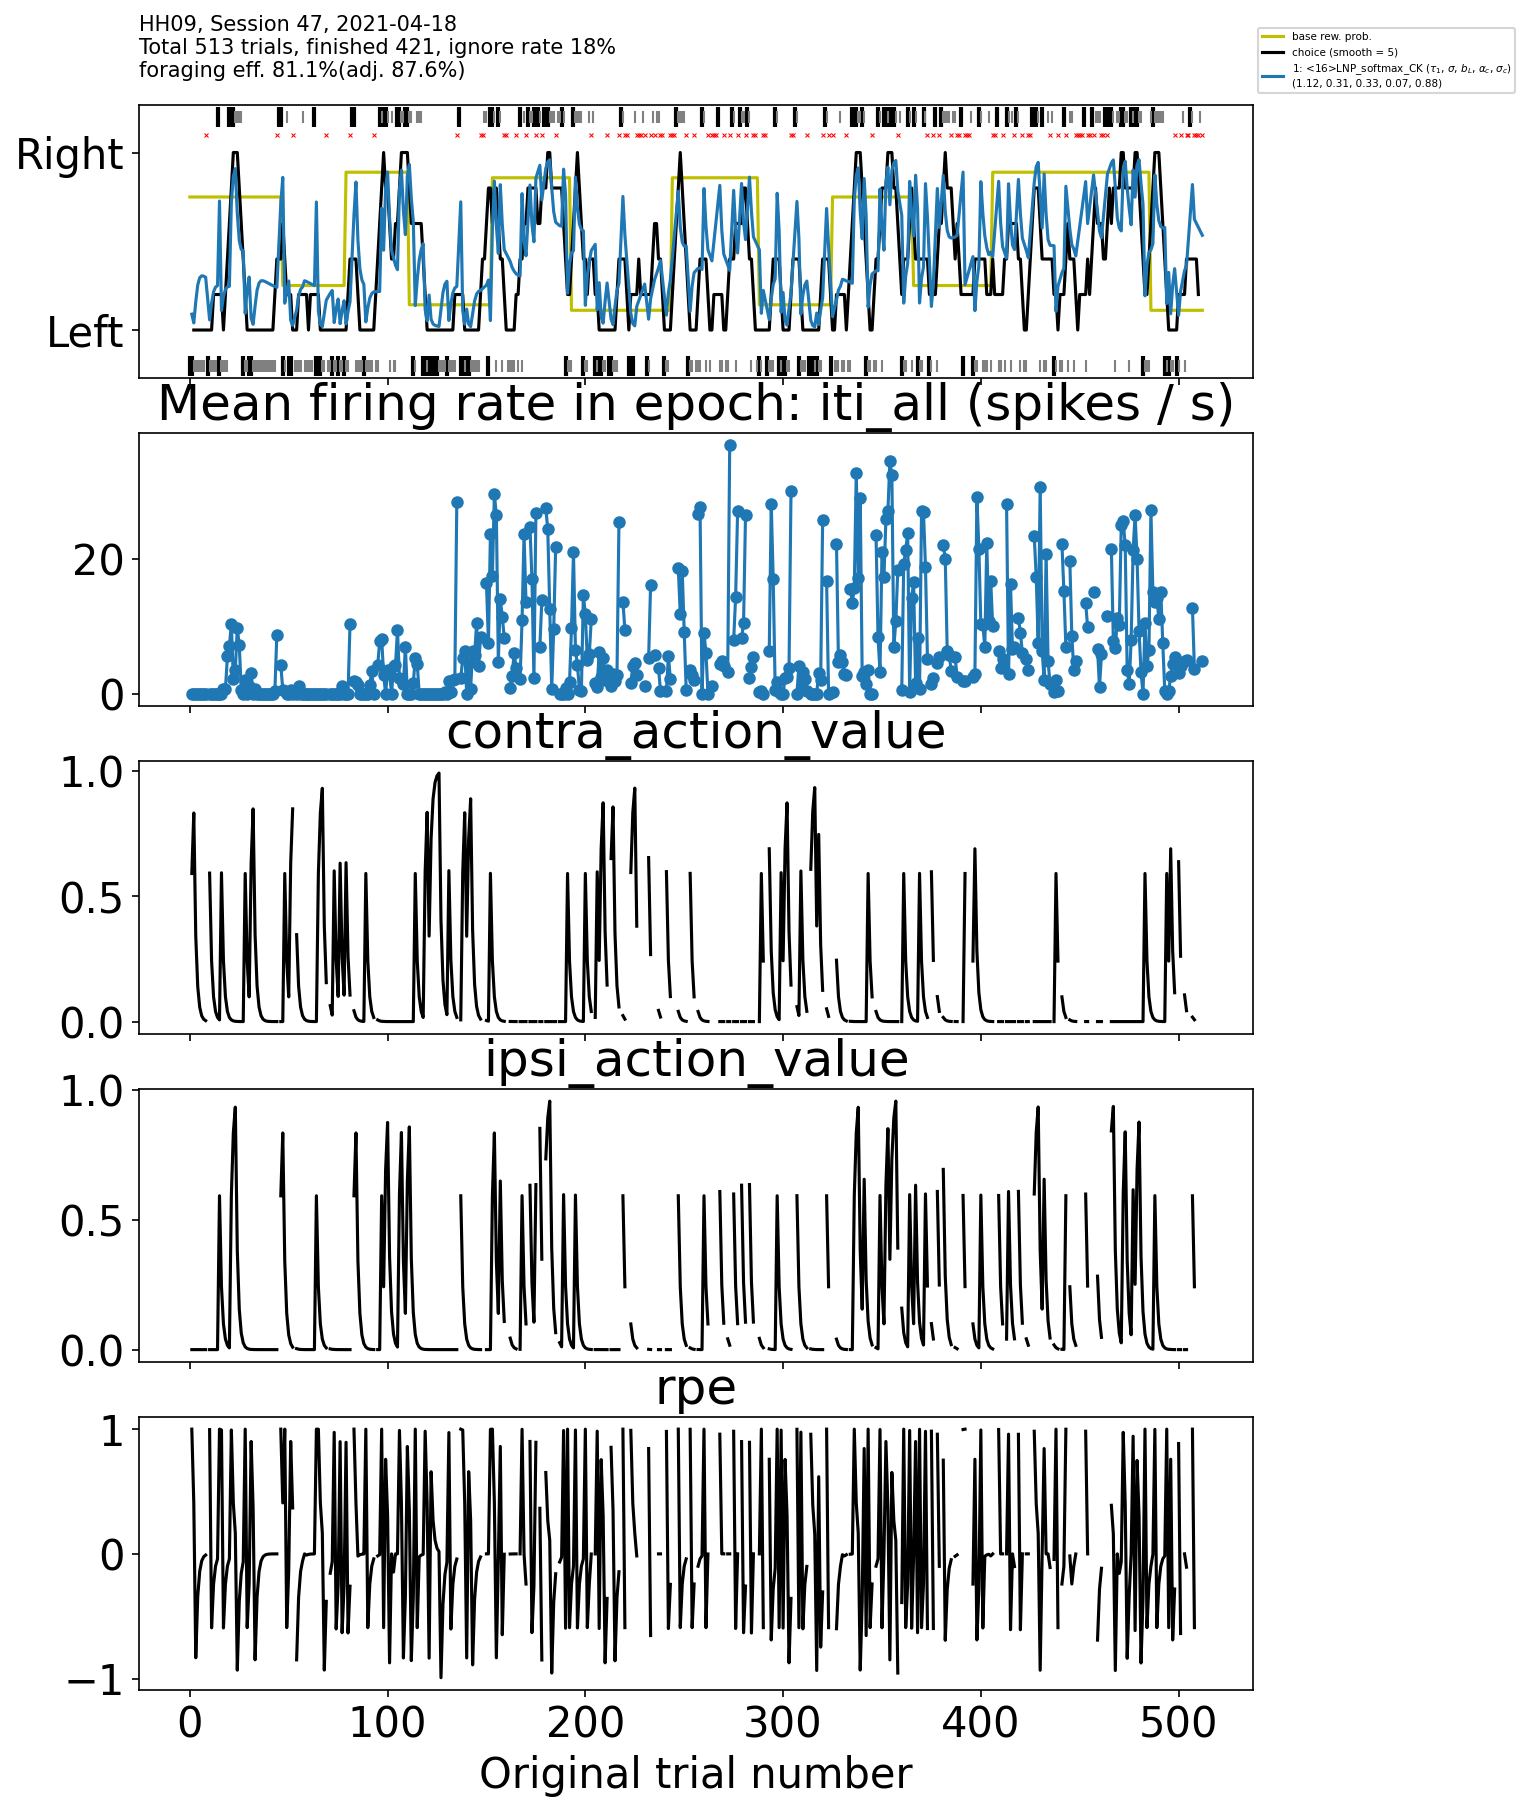

<Figure size 1600x600 with 0 Axes>

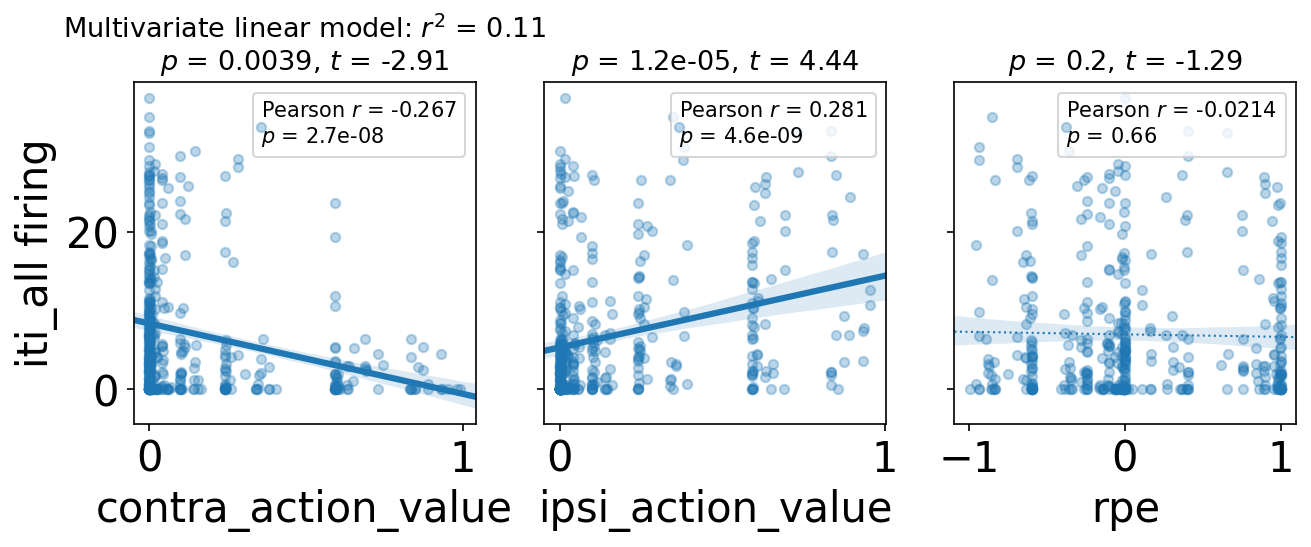

In [5]:
_ = unit_psth.plot_unit_period_tuning(unit_key, period='iti_all', independent_variable = ['contra_action_value', 'ipsi_action_value', 'rpe'])

## Noise correlation

As the first step of computing noise correlation, we can use `psth_foraging.compute_unit_period_activity` to get spike counts over trials for each unit.

In [10]:
from pipeline import psth_foraging

In [ ]:
psth_foraging.compute_unit_period_activity(unit_key=unit_key, period='iti_all')

Get raw raster (example from `pipeline\plot\unit_psth\plot_unit_psth_choice_outcome`)

In [ ]:
left_hit_trials = psth_foraging.TrialCondition.get_trials('R_hit', 0) & unit_key
left_hit_unit_psth = psth_foraging.compute_unit_psth_and_raster(unit_key, left_hit_trials, align_type='iti_start')
left_hit_unit_psth.keys()

In [22]:
left_hit_unit_psth['psth_per_trial'].shape

(66, 324)

The example above selects trials according to choice and outcome. 

If you want to get all trials, use this

In [37]:
all_unit_psth = psth_foraging.compute_unit_psth_and_raster(unit_key, experiment.BehaviorTrial & unit_key, align_type='iti_start')
all_unit_psth['psth_per_trial'].shape

(513, 324)

Or, if you want to select trials according to other variables such as action value, this will be helpful:

In [33]:
from pipeline.util import _get_unit_independent_variable
df = _get_unit_independent_variable(unit_key, model_id=10)
df

,trial,subject_id,session,model_id,left_,right_,contra_,ipsi_,left_action_value,right_action_value,...,ipsi_choice_kernel,relative_action_value_lr,relative_action_value_ic,total_action_value,choice,choice_lr,choice_ic,outcome,reward,rpe
0,1,473361,47,10,left,right,left,right,0.455350,0.000000,...,NaN,-0.45535,0.45535,0.45535,left,0,1,hit,1,1.0
1,2,473361,47,10,left,right,left,right,0.703356,0.000000,...,NaN,-0.703356,0.703356,0.703356,left,0,1,hit,1,0.54465
2,3,473361,47,10,left,right,left,right,0.383083,0.000000,...,NaN,-0.383083,0.383083,0.383083,left,0,1,miss,0,-0.703356
3,4,473361,47,10,left,right,left,right,0.208646,0.000000,...,NaN,-0.208646,0.208646,0.208646,left,0,1,miss,0,-0.383083
4,5,473361,47,10,left,right,left,right,0.113639,0.000000,...,NaN,-0.113639,0.113639,0.113639,left,0,1,miss,0,-0.208646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,503,473361,47,10,left,right,left,right,0.163383,0.000171,...,NaN,-0.163211,0.163211,0.163554,right,1,0,miss,0,-0.000314
417,504,473361,47,10,left,right,left,right,0.088986,0.000093,...,NaN,-0.088893,0.088893,0.08908,left,0,1,miss,0,-0.163383
418,507,473361,47,10,left,right,left,right,0.048466,0.455401,...,NaN,0.406934,-0.406934,0.503867,right,1,0,hit,1,0.999907
419,508,473361,47,10,left,right,left,right,0.026397,0.248034,...,NaN,0.221637,-0.221637,0.274431,right,1,0,miss,0,-0.455401


# Model fitting results

## All models

In [ ]:
foraging_model.Model()

Show param settings of a specified model

In [ ]:
foraging_model.Model.Param & 'model_id=25'

## All model comparison groups

In [ ]:
foraging_model.ModelComparison()

In [6]:
lab.WaterRestriction & 'water_restriction_number = "HH07"'

subject_id institution 6 digit animal ID,water_restriction_number WR number,cage_number,wr_start_date,wr_start_weight
472184,HH07,176952,2020-08-24,30.000


## Example session

`model_comparison_idx` = 1: all models with bias term<br>
`sort='aic'`: sorted by AIC, from best to worst

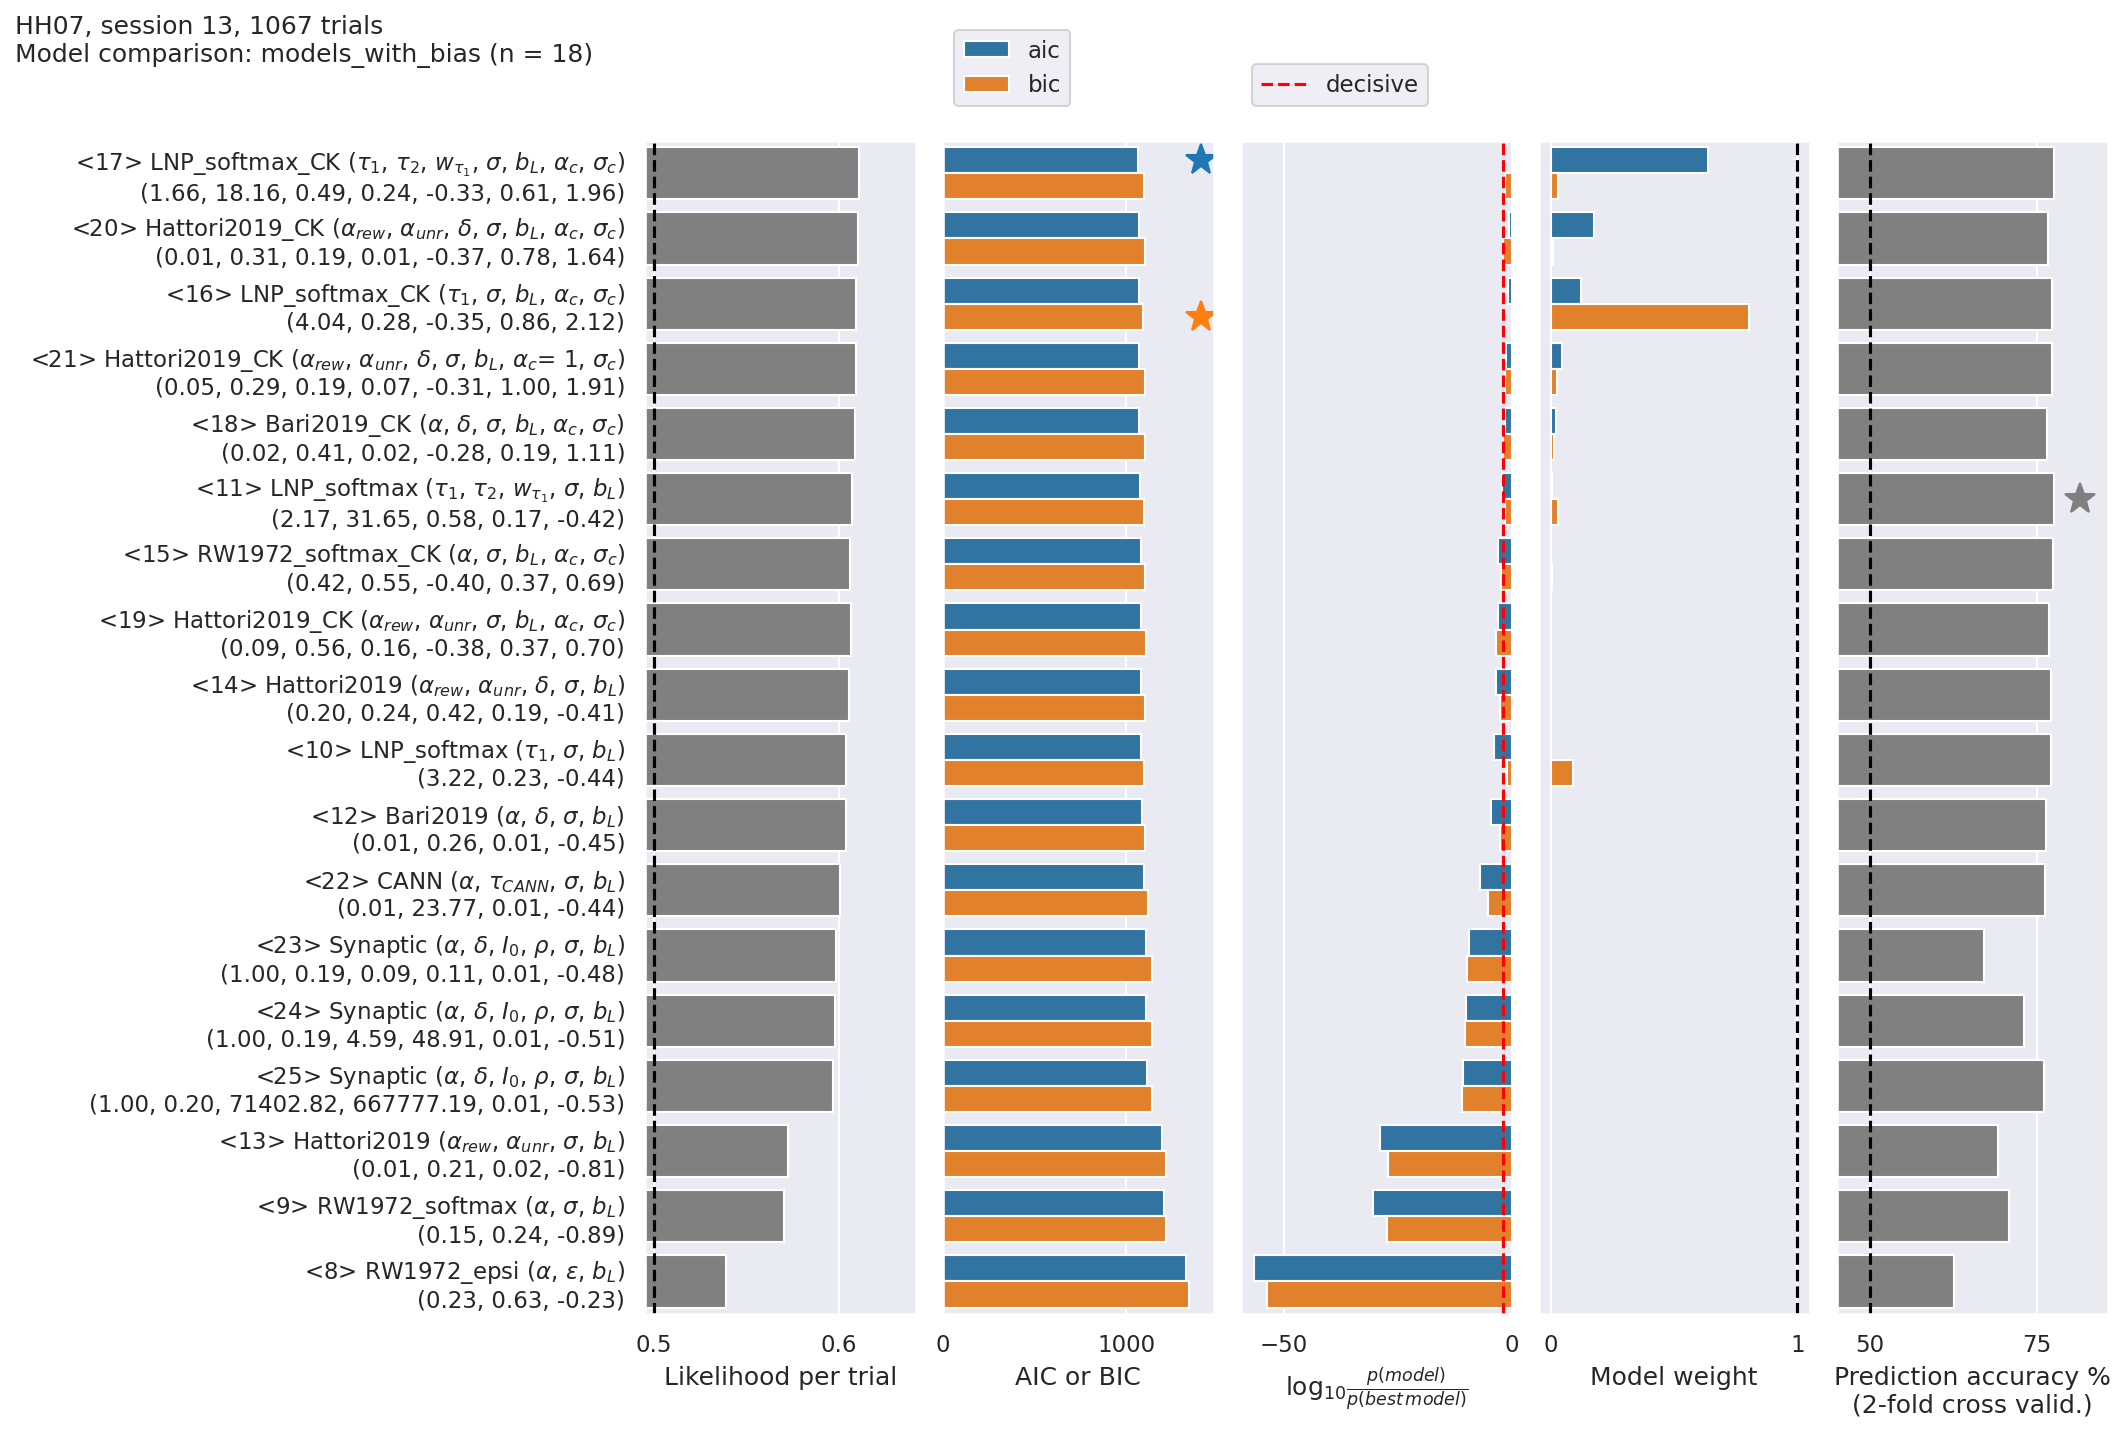

In [7]:
sess_key = {'subject_id': 472184, 'session': 13}
plot_session_model_comparison(sess_key, model_comparison_idx=1, sort='aic')

Raw fitted results

In [ ]:
foraging_model.Model.proj('model_notation') * (foraging_model.FittedSessionModel & sess_key) 

Plot fitted choice traces of best and worst models

In [9]:
%matplotlib qt5
_ = plot_session_fitted_choice(sess_key=sess_key, first_n=1, last_n=2, smooth_factor=10, model_comparison_idx=1)

Plot specified models

CANN model (22), Synaptic (23), and Hattori (14)

In [ ]:
_ = plot_session_fitted_choice(sess_key=sess_key, specified_model_ids=[22, 24, 14], smooth_factor=10)

## Query of fitted params

All fitted params are stored in the part table `foraging_model.FittedSessionModel.Param`

In [ ]:
foraging_model.FittedSessionModel.Param.heading

Models from Ulises

In [ ]:
Ulises_model = (foraging_model.Model & 'model_class in ("CANN", "Synaptic")')
Ulises_model

Show fit command

In [ ]:
Ulises_model.fetch('fit_cmd')

Note the different bounds of $I_0$ and $\rho$ of the three Synaptic models.<br>
- `model_id = 23` --> $0 < I_0 < 10, 0 < \rho < 1$
- `model_id = 24` --> $0 < I_0 < 10, -100 < \rho < 100$
- `model_id = 25` --> $0 < I_0 < 1e6, -1e6 < \rho < 1e6$ (basically unconstrained)

Say, we're interested in the fully unconstrained Synaptic model (`model_id = 25`)

In [ ]:
model_id = 25

Query ALL fitted params for one session

In [ ]:
# From foraging_model.Model, we know model_id 24 is the Synaptic model
foraging_model.FittedSessionModel.Param & {'subject_id': 482350, 'session': 52, 'model_id': model_id}

Quecy one fitted parmas, say, the `forget_rate`, for All sessions 

In [ ]:
foraging_model.FittedSessionModel.Param & {'model_param': 'forget_rate', 'model_id': model_id}

Plot distributions of fitted params (`learn_rate` and `tau` of the RNN model)

In [ ]:
model_id = 22
params = ['learn_rate', 'tau_cann']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

## Problems in Synaptic model?

For `model_id = 23`,  Some fitted $\rho$s are at the boundary 0 and 1

- `model_id = 23` --> $0 < I_0 < 10, 0 < \rho < 1$

In [ ]:
model_id = 23
params = ['learn_rate', 'forget_rate', 'I0', 'rho']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

- `model_id = 24` --> $0 < I_0 < 10, -100 < \rho < 100$

In [ ]:
model_id = 24
params = ['learn_rate', 'forget_rate', 'I0', 'rho']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

- `model_id = 25` --> $0 < I_0 < 1e6, -1e6 < \rho < 1e6$ (basically unconstrained)

$\rho$ is clearly problematic if unconstrained...

In [ ]:
model_id = 25
params = ['learn_rate', 'forget_rate', 'I0', 'rho']
fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 5))

for ax, param in zip(axs, params):
    q = (foraging_model.FittedSessionModel.Param & {'model_id': model_id, 'model_param': param}).fetch('fitted_value')
    ax.hist(q, 100)
    ax.set_xlabel(param)

In the following example, `model_id=23` failed, but `24` and `25` look fine, although there's a clear overfitting in `25` (huge $I_0$ and $\rho$)

In [ ]:
key = (experiment.Session & (foraging_model.FittedSessionModel & 'model_id = 23')).fetch('KEY', limit=1, offset=9)[0]
plot_session_fitted_choice(key, specified_model_ids=[9, 22, 23, 24, 25])

### Find good example session for Ulises

<AxesSubplot:xlabel='Trial number (finished trials only)'>

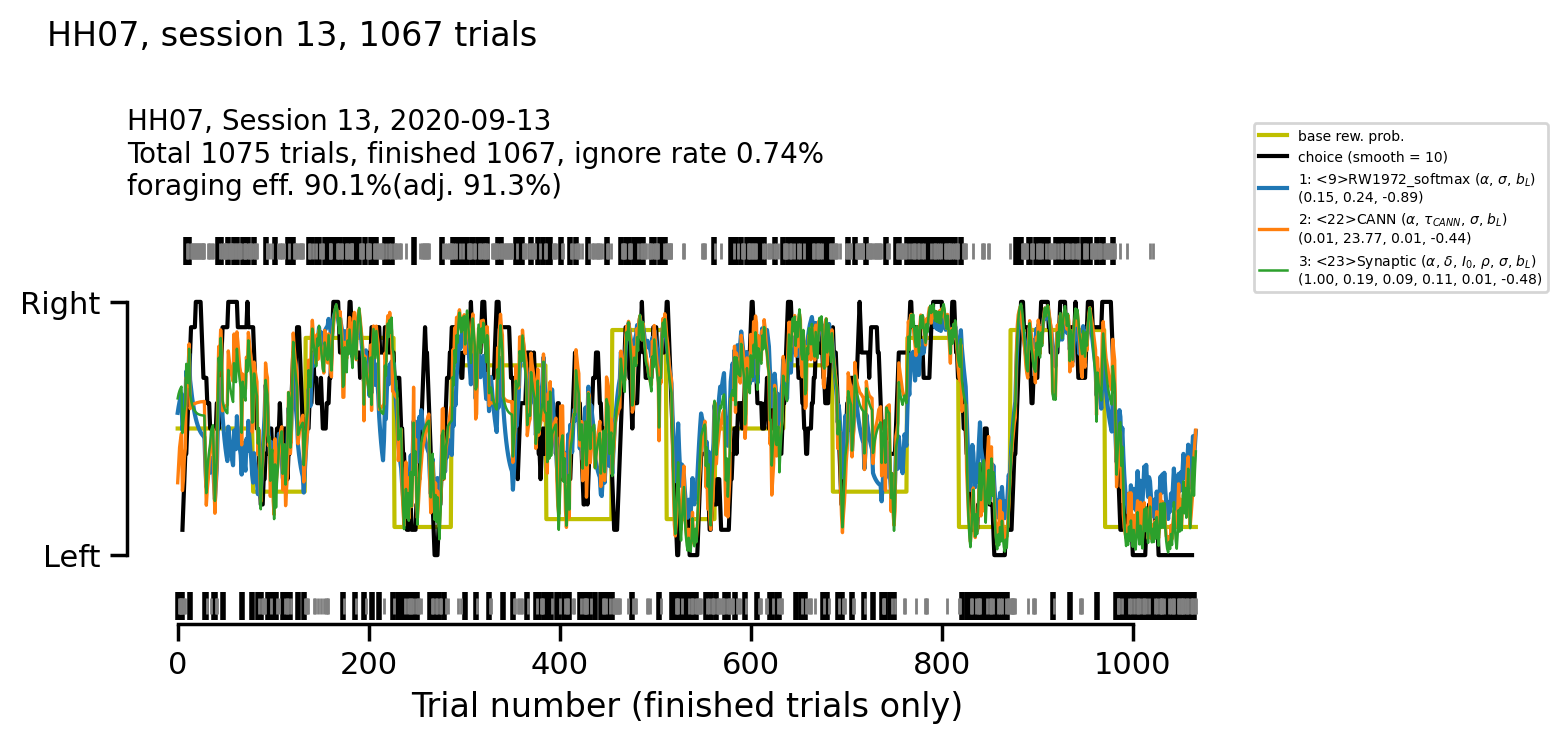

In [27]:
session = experiment.Session & (lab.WaterRestriction & 'water_restriction_number = "HH07"') & 'session = 13' 
plot_session_fitted_choice(sess_key=session.fetch1('KEY'), specified_model_ids=[9, 22, 23], smooth_factor=10)

## Compare models by AIC

Here I'm comparing overal fitting qualities of five models

`lpt_aic` is the likelihood per trial with AIC penality (the larger, the better)

In [ ]:
model_ids = [9, 22, 23, 24, 25]
_, ax = plt.subplots(1, 1, figsize=(10, 10))

for model_id in model_ids:
    lpt_aic = (foraging_model.FittedSessionModel & {'model_id': model_id}).fetch('lpt_aic')
    cnt, bin = np.histogram(lpt_aic, bins=100)
    plt.plot(bin[:-1], np.cumsum(cnt), lw=3, label=(foraging_model.Model & {'model_id': model_id}).fetch('desc'))

ax.set(xlabel='likelihood per trial (aic penality)', ylabel='cumulative prob')
_ = ax.legend(bbox_to_anchor=[1, 1])    

Conclusion:
1. `CANN` is better than `SuttonBarto` (which is the same as `CANN` except the ITI-dependent decay)
2. Mildly constrained Synaptic model `24` (red) is better than tightly constrained `23` (green) or unconstrained `25` (purple) models.

In [26]:
sess_key = {'subject_id': 473361, 'session': 46}

# Retrieve fitted latent variables

## Action value

In current model fitting pipeline, `action value` and `choice probability` of each trial have been saved in part table `TrialLatentVariable` by default.

In [12]:
foraging_model.FittedSessionModel.TrialLatentVariable.heading

# 
subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
model_id             : int                          # 
trial                : smallint                     # trial number (1-based indexing)
water_port           : varchar(16)                  # e.g. left, right, middle, top-left, purple
---
action_value=null    : float                        # 
choice_prob=null     : float                        # 
choice_kernel=null   : float                        # 

In [ ]:
latent_variables = foraging_model.FittedSessionModel.TrialLatentVariable & sess_key & 'model_id = 21'
latent_variables

In [ ]:
latent_variables * experiment.BehaviorTrial * experiment.WaterPortChoice.proj(choice='water_port') & 'choice = "right"' & 'outcome = "hit"'

In [97]:
sess_key = {'subject_id': 473361, 'session': 46}

In [ ]:
latent_variables = foraging_model.FittedSessionModel.TrialLatentVariable & sess_key & 'model_id = 22'
(experiment.BehaviorTrial & sess_key ) - latent_variables

In [93]:
dj.U('subject_id', 'session') & (((experiment.BehaviorTrial & sess_key) - (foraging_model.FittedSessionModel.TrialLatentVariable & 'model_id = 22' & sess_key)) & 'outcome != "ignore"')

subject_id institution 6 digit animal ID,session session number
473361,46


In [ ]:
all_22 = dj.U('subject_id', 'session') &  (foraging_model.FittedSessionModel.TrialLatentVariable & 'model_id = 22')
all_22 * lab.WaterRestriction

In [ ]:
experiment.BehaviorTrial & sess_key & 'outcome="ignore"'

In [14]:
experiment.WaterPortChoice.heading

# The water port selected by the animal for each trial
subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
trial                : smallint                     # trial number (1-based indexing)
---
water_port=null      : varchar(16)                  # e.g. left, right, middle, top-left, purple

So we can plot the fitted `action values` (red and green, on left axis) together with the fitted choice probability (blue).

For the synaptic model, `action values` = $u_L$ and $u_R$

In [ ]:
right_action_value = (latent_variables & 'water_port = "right"').fetch('action_value')
left_action_value = (latent_variables & 'water_port = "left"').fetch('action_value')

ax = plot_session_fitted_choice(sess_key=sess_key, specified_model_ids=24, smooth_factor=10)
ax2 = ax.twinx()
ax2.plot(right_action_value, 'g', label='right action value')
ax2.plot(left_action_value, 'r', label='left action value')
ax2.set_ylabel('action value')
ax2.legend(fontsize=7)

## $w_L(k)$ and $w_R(k)$

Unfortunately, I didn't save $w(k)$ in the latent variable table. But we can recompute them by simulating the fitted model again.

In [ ]:
def plot_fitted_synaptic_w(sess_key, synaptic_model_id=24):
    # Retrieve fitted parameters
    fitted_para = (foraging_model.FittedSessionModel.Param & sess_key & f'model_id = {synaptic_model_id}').fetch()
    model_name = (foraging_model.Model & f'model_id = {synaptic_model_id}').fetch1('model_class')
    params = {name: value for (_, _, _, name, value) in fitted_para}

    # Retrieve choice and reward history
    choice_history, reward_history, iti, p_reward, q_choice_outcome = foraging_model.get_session_history(sess_key)

    # Rerun the model
    from pipeline.model.bandit_model import BanditModel
    model = BanditModel(forager=model_name, **params, fit_choice_history=choice_history, fit_reward_history=reward_history)
    model.simulate()
    
    # Plot the fitted w and the fitted choice
    w_L, w_R = model.w

    ax = plot_session_fitted_choice(sess_key=sess_key, specified_model_ids=synaptic_model_id, smooth_factor=10)
    ax2 = ax.twinx()
    ax2.plot(w_R, 'g', label='$w_R$', lw=1)
    ax2.plot(w_L, 'r', label='$w_L$', lw=1)
    ax2.set_ylabel('w')
    ax2.legend(fontsize=10)

Call this function with any session and any synaptic model.

The following two figures are model 23 and 24 using the same session.

In [ ]:
plot_fitted_synaptic_w(sess_key={'subject_id': 447921, 'session': 12}, synaptic_model_id=23)

In [ ]:
plot_fitted_synaptic_w(sess_key={'subject_id': 447921, 'session': 12}, synaptic_model_id=24)

In [13]:
from pipeline.plot import foraging_plot

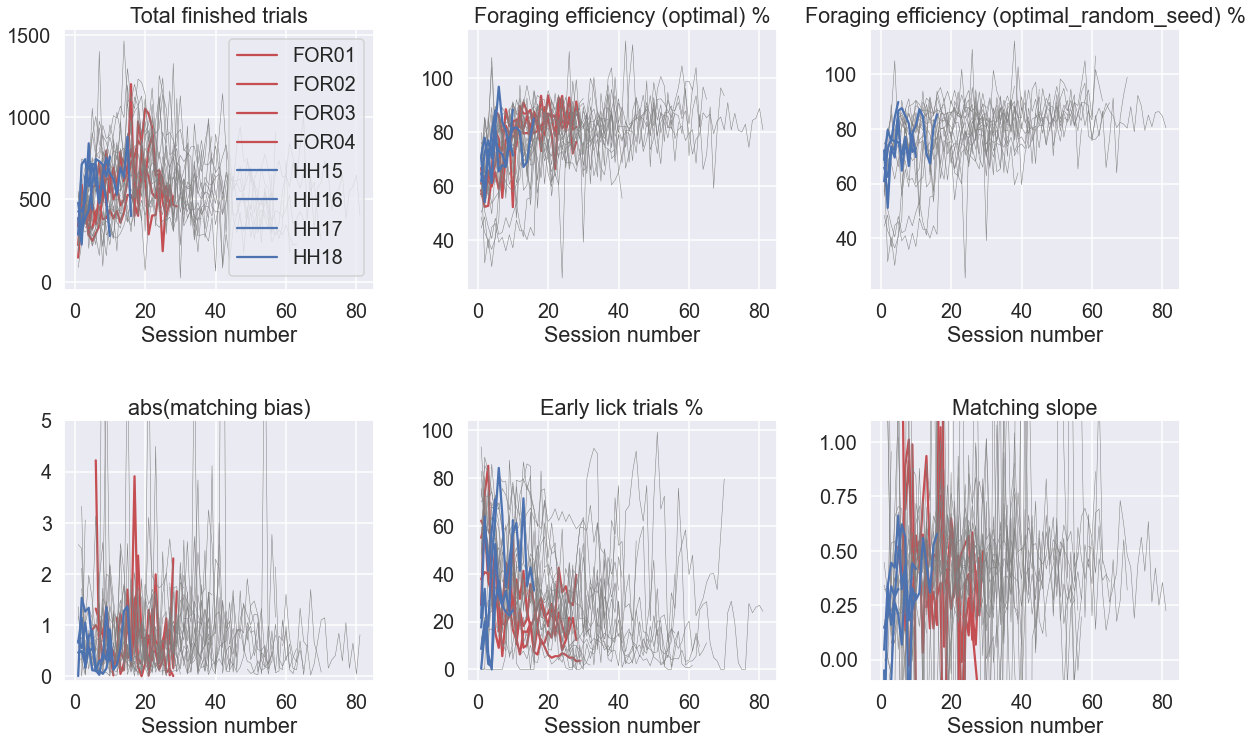

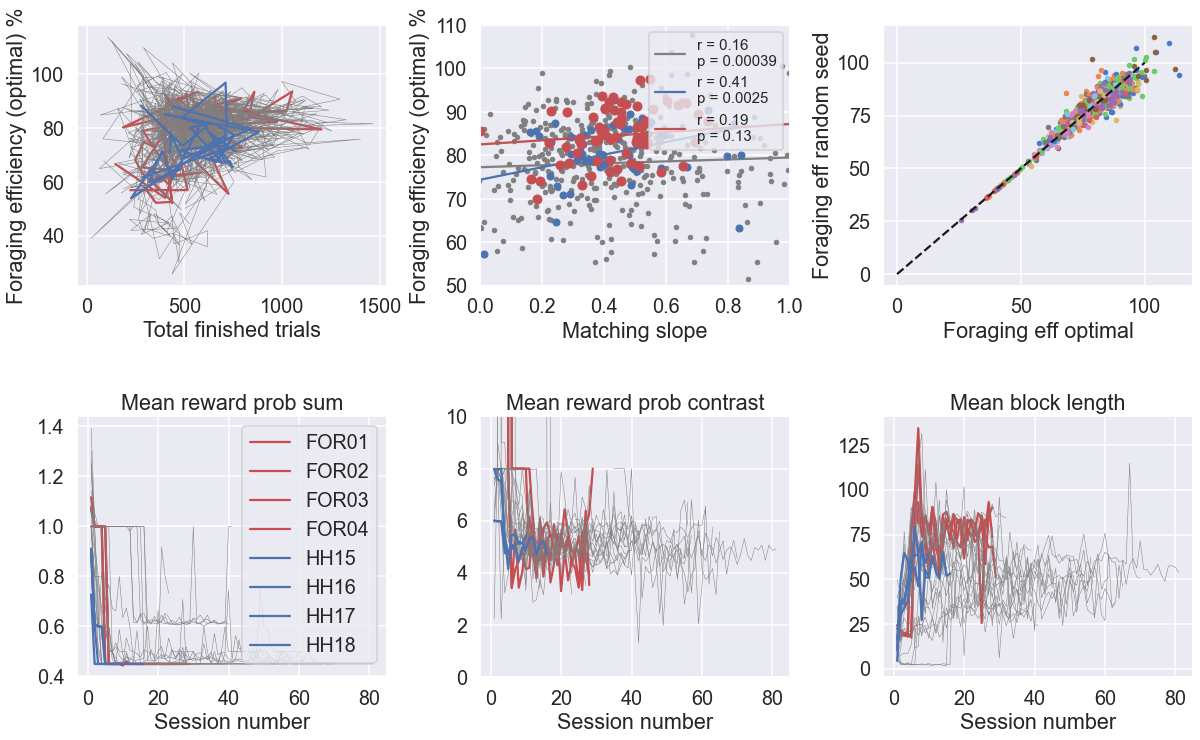

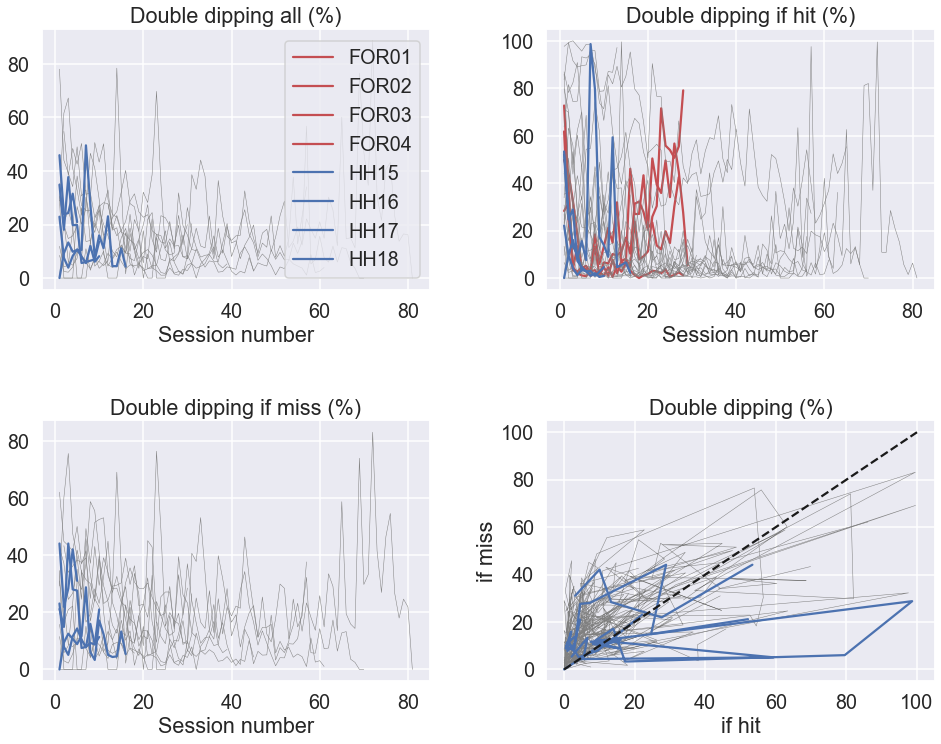

In [15]:
foraging_plot.plot_training_summary()